# Project 1: Hierarchical Poisson Factorization
## Building Recommender Systems With Markovian Inference

In [1]:
using CSV
using DataFrames
using Plots
using Dates
using Statistics
using StatsBase
using Pipe
using CategoricalArrays
using DataFramesMeta

## Dataset selection

Selection criteria:
1. manageable size (<= 100k-150k samples)
2. big enough (>= 10k samples)
3. time ordered events
4. multiple product categories
5. numerical ratings

The following candidates were evaluated:

In [2]:
DataFrame(
    candidate=[
        "Amazon beauty", 
        "Indonesia tourism", 
        "Electronics eCommerce",
        "ModCloth ratings",
        "Amazon books"
        ],
    manageable_size=["❌", "✅", "❌", "✅", "❌"],
    big_enough=["✅", "✅", "✅", "✅", "✅"],
    time_ordered_events=["✅", "❌", "✅", "✅", "❌"],
    multiple_product_categories=["❌", "✅", "✅", "✅", "❌"],
    numerical_ratings=["✅", "✅", "❌", "✅", "❌"]
)

Row,candidate,manageable_size,big_enough,time_ordered_events,multiple_product_categories,numerical_ratings
,String,String,String,String,String,String
1,Amazon beauty,❌,✅,✅,❌,✅
2,Indonesia tourism,✅,✅,❌,✅,✅
3,Electronics eCommerce,❌,✅,✅,✅,❌
4,ModCloth ratings,✅,✅,✅,✅,✅
5,Amazon books,❌,✅,❌,❌,❌


## Dataset exploration: ModCloth ratings

Available at: https://www.kaggle.com/datasets/ruchi798/marketing-bias-in-product-recommendations?select=modcloth.csv

Dataset description:
* User to item ratings with scors from 1 to 5
* Events from 2010 to 2020
* Also contains category, brand, model size, user size, how the item fits
* No pricing details

Dataset cleaning:
* Keep only user - item, category, time and rating
* Discard all entries with missing values

In [3]:
# Median for datetime, taken from Reddit: 
# https://www.reddit.com/r/Julia/comments/hrfpei/defining_a_median_method_for_datetime/
Statistics.median(dateTimeArray::Array{DateTime,1}) =  DateTime(Dates.UTM(Int(round(median(Dates.value.(dateTimeArray))))))

ratings_df = CSV.read("modcloth.csv", DataFrame)

function prepare!(df)
    parse_timestamp = timestamp -> DateTime(replace(timestamp, "+00:00" => ""), "y-m-d H:M:S.s")
    ratings_df.item_id = string.(ratings_df.item_id)
    ratings_df.time = map(parse_timestamp, ratings_df.timestamp)
    ratings_df.rating_score = ratings_df.rating
    select!(ratings_df, Not([:timestamp, :brand, :year, :rating, :fit, :size, :user_attr, :model_attr, :split]))
    dropmissing!(ratings_df)
end

prepare!(ratings_df)
@assert size(ratings_df) == (99893, 5) 
summary(ratings_df)

"99893×5 DataFrame"

In [4]:
first(ratings_df, 10)

Row,item_id,user_id,category,time,rating_score
,String,String,String15,DateTime,Int64
1,7443,Alex,Dresses,2010-01-21T08:00:00,4
2,7443,carolyn.agan,Dresses,2010-01-27T08:00:00,3
3,7443,Robyn,Dresses,2010-01-29T08:00:00,4
4,7443,De,Dresses,2010-02-13T08:00:00,4
5,7443,tasha,Dresses,2010-02-18T08:00:00,4
6,7443,gina.chihos,Dresses,2010-02-25T08:00:00,5
7,7443,Kim,Dresses,2010-02-26T08:00:00,2
8,7443,jess.betcher,Dresses,2010-03-26T07:00:00,5
9,7443,Elissa,Dresses,2010-04-06T07:00:00,4


In [5]:
describe(ratings_df, :first, :eltype, :nunique, :min, :median, :max)

Row,variable,first,eltype,nunique,min,median,max
,Symbol,Any,DataType,Union…,Any,Any,Any
1,item_id,7443,String,1020,102736,,89044
2,user_id,Alex,String,44784,"""Ferrari"")",,😊
3,category,Dresses,String15,4,Bottoms,,Tops
4,time,2010-01-21T08:00:00,DateTime,14741,2010-01-21T08:00:00,2016-01-26T08:00:00,2019-06-29T13:55:16.542
5,rating_score,4,Int64,,1,5.0,5


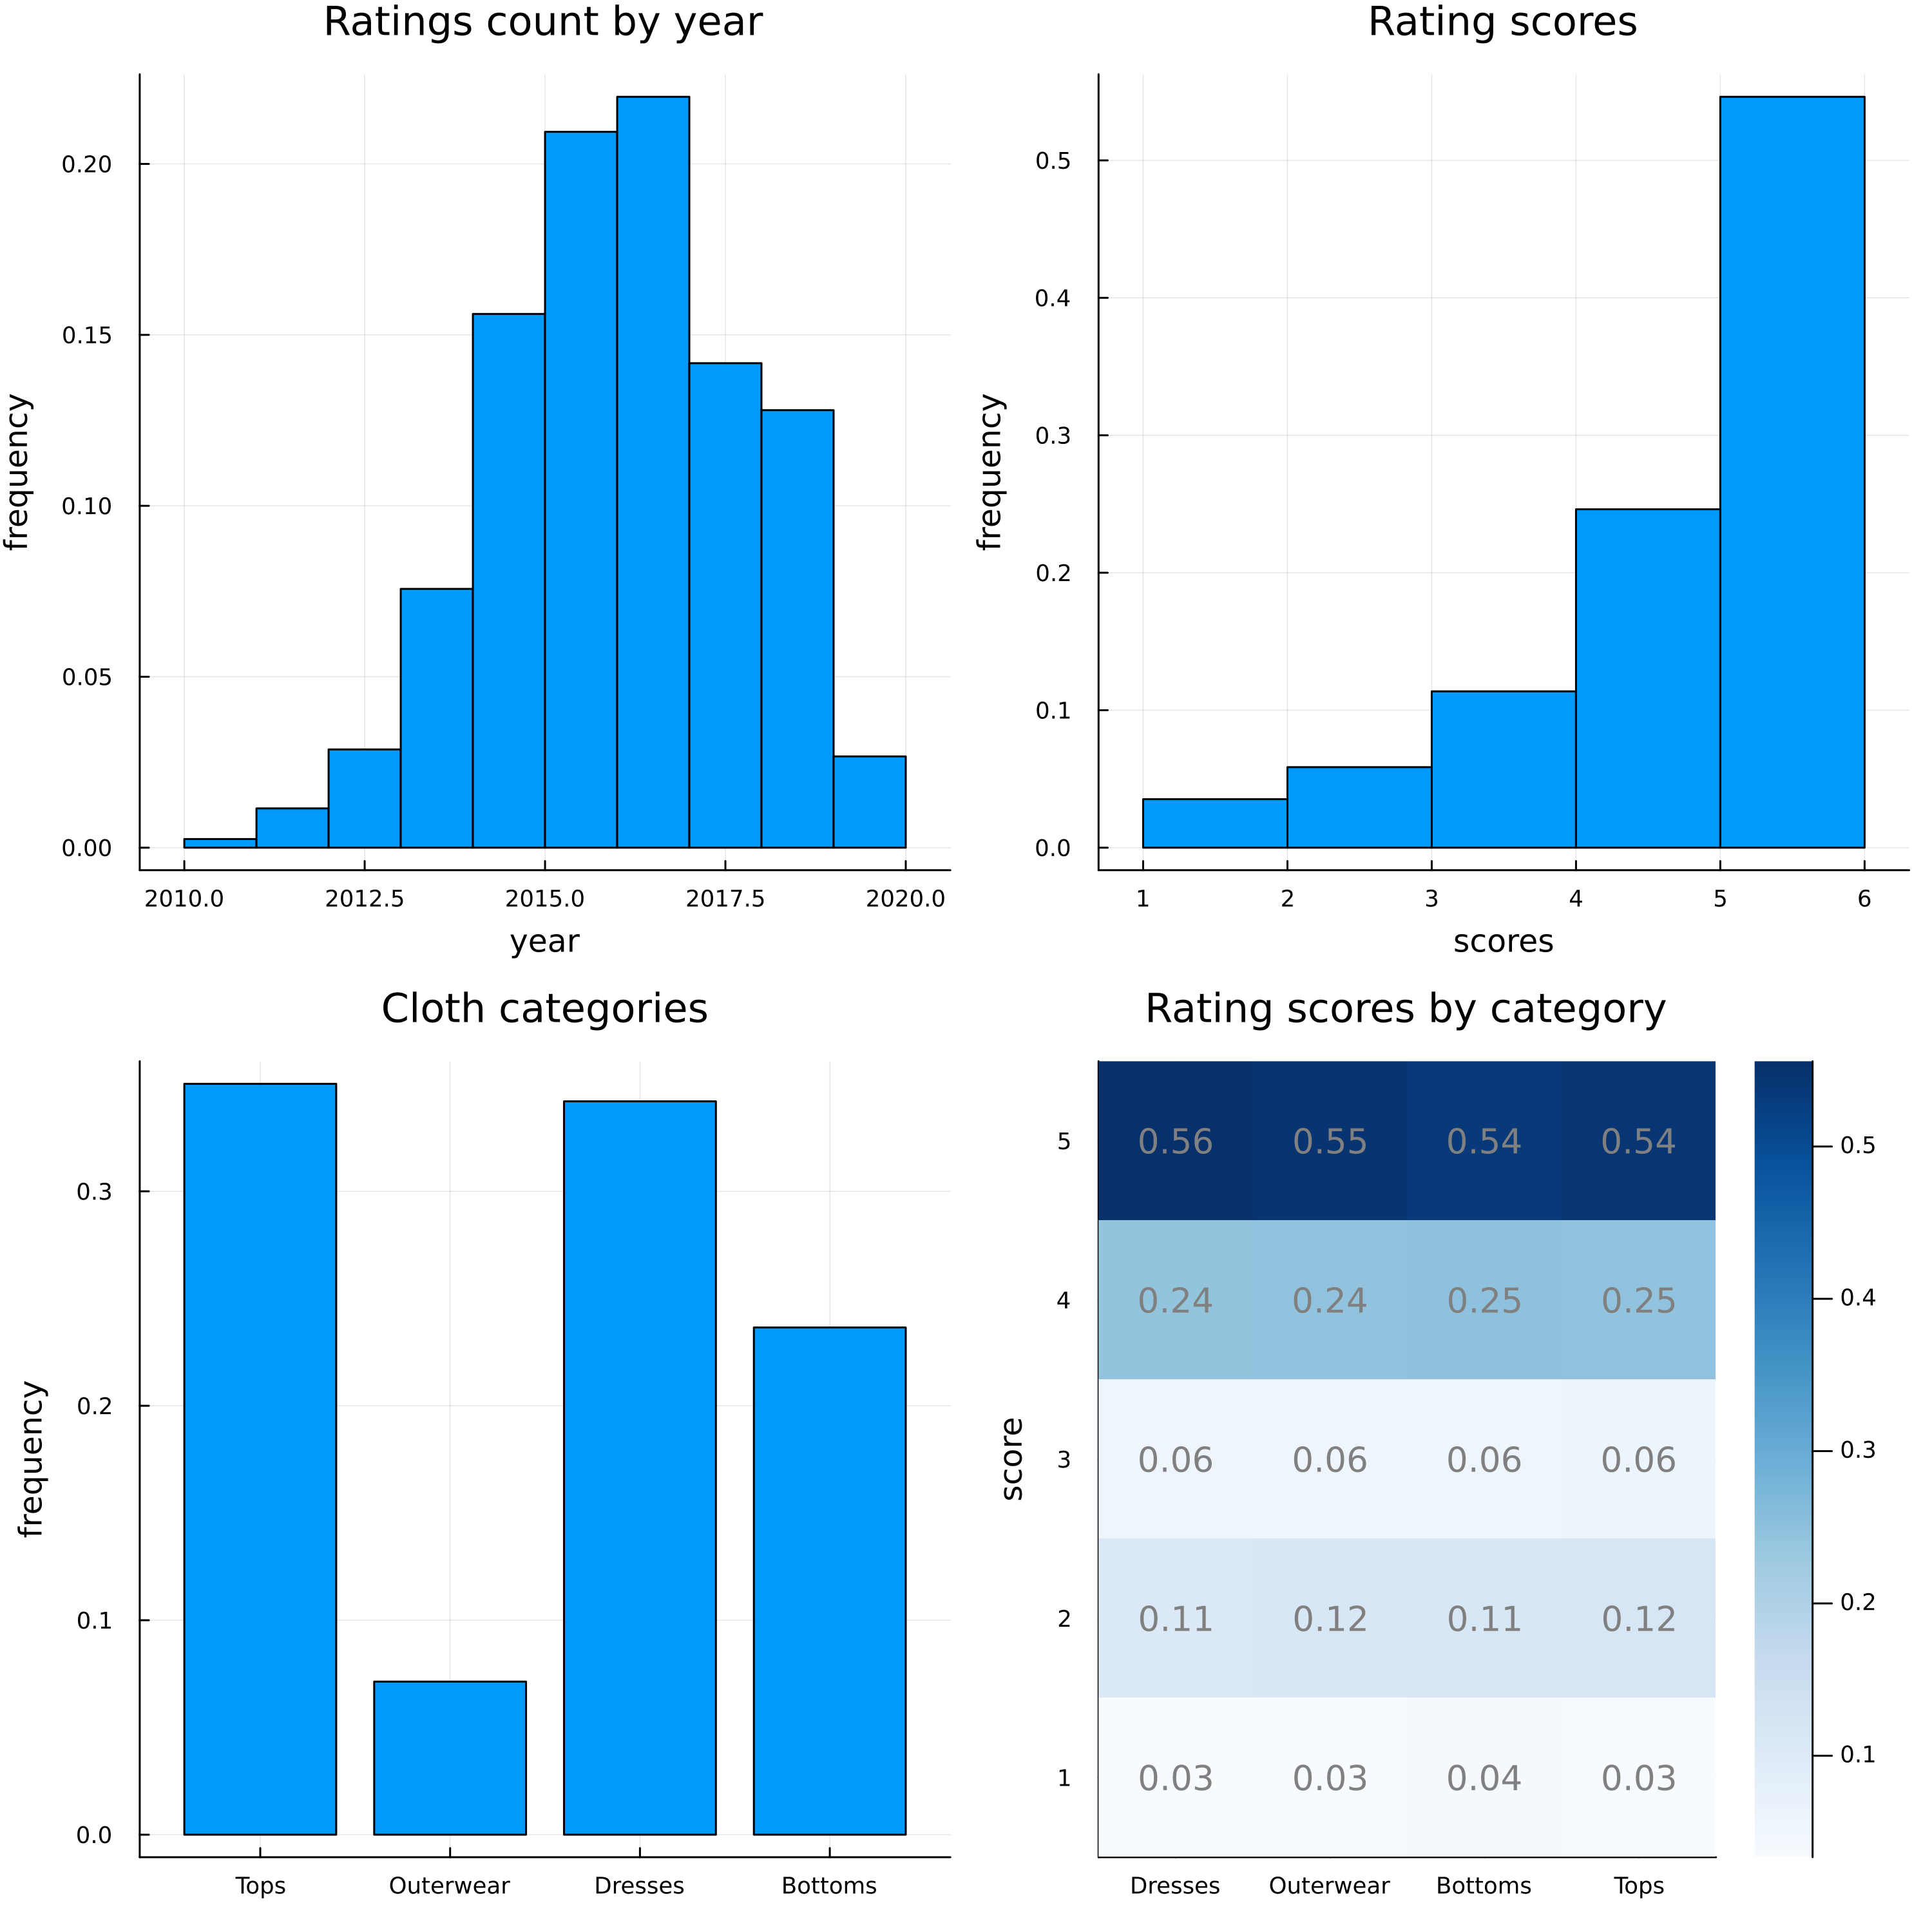

In [6]:
function make_data_distribution_plots(df)
    categories, scores_matrix = get_scores_by_category(df)
    
    plots = [
        histogram(
            map(t -> Dates.year(t), df.time), 
            title="Ratings count by year",
            label="ratings",
            xlabel="year",
            ylabel="frequency",
            bins=10, 
            normalize=true
        ),

        histogram(
            df.rating_score, 
            title="Rating scores",
            label="ratings",
            xlabel="scores",
            ylabel="frequency",
            bins=6, 
            normalize=true
        ),

        bar(
            proportionmap(df.category),
            title="Cloth categories",
            ylabel="frequency",
        ),

        heatmap(
            categories, 
            1:5, 
            scores_matrix,
            title="Rating scores by category",
            ylabel="score",
            c=:Blues,
            annotations=heatmap_annotation(scores_matrix),
        ),
    ]
    
    return plot(plots..., layout=(2,2), legend=false, size=(1000, 1000), fmt = :png, dpi=300)
end
    

function groupby_count(df, column)
    return @pipe groupby(df, column) |> 
        combine(_, nrow => :count) |> 
        sort(_, :count, rev=true)
end

function get_scores_by_category(df)
    scores_by_categ = @pipe groupby(df, :category) |> combine(_, :rating_score .=> proportionmap)
    scores_matrix = scores_by_categ.rating_score_proportionmap .|> values .|> collect .|> reverse
    scores_matrix = hcat(scores_matrix...)
        
    return scores_by_categ.category, scores_matrix
end
        
function heatmap_annotation(matrix)
    rows, columns = size(matrix)
    return [
        (j - 0.5, i, 
            text(
                round(matrix[i, j], digits=2),
                12,
                :gray,
                :center
            ), 
        ) for i in 1:rows for j in 1:columns
    ]
end

make_data_distribution_plots(ratings_df)

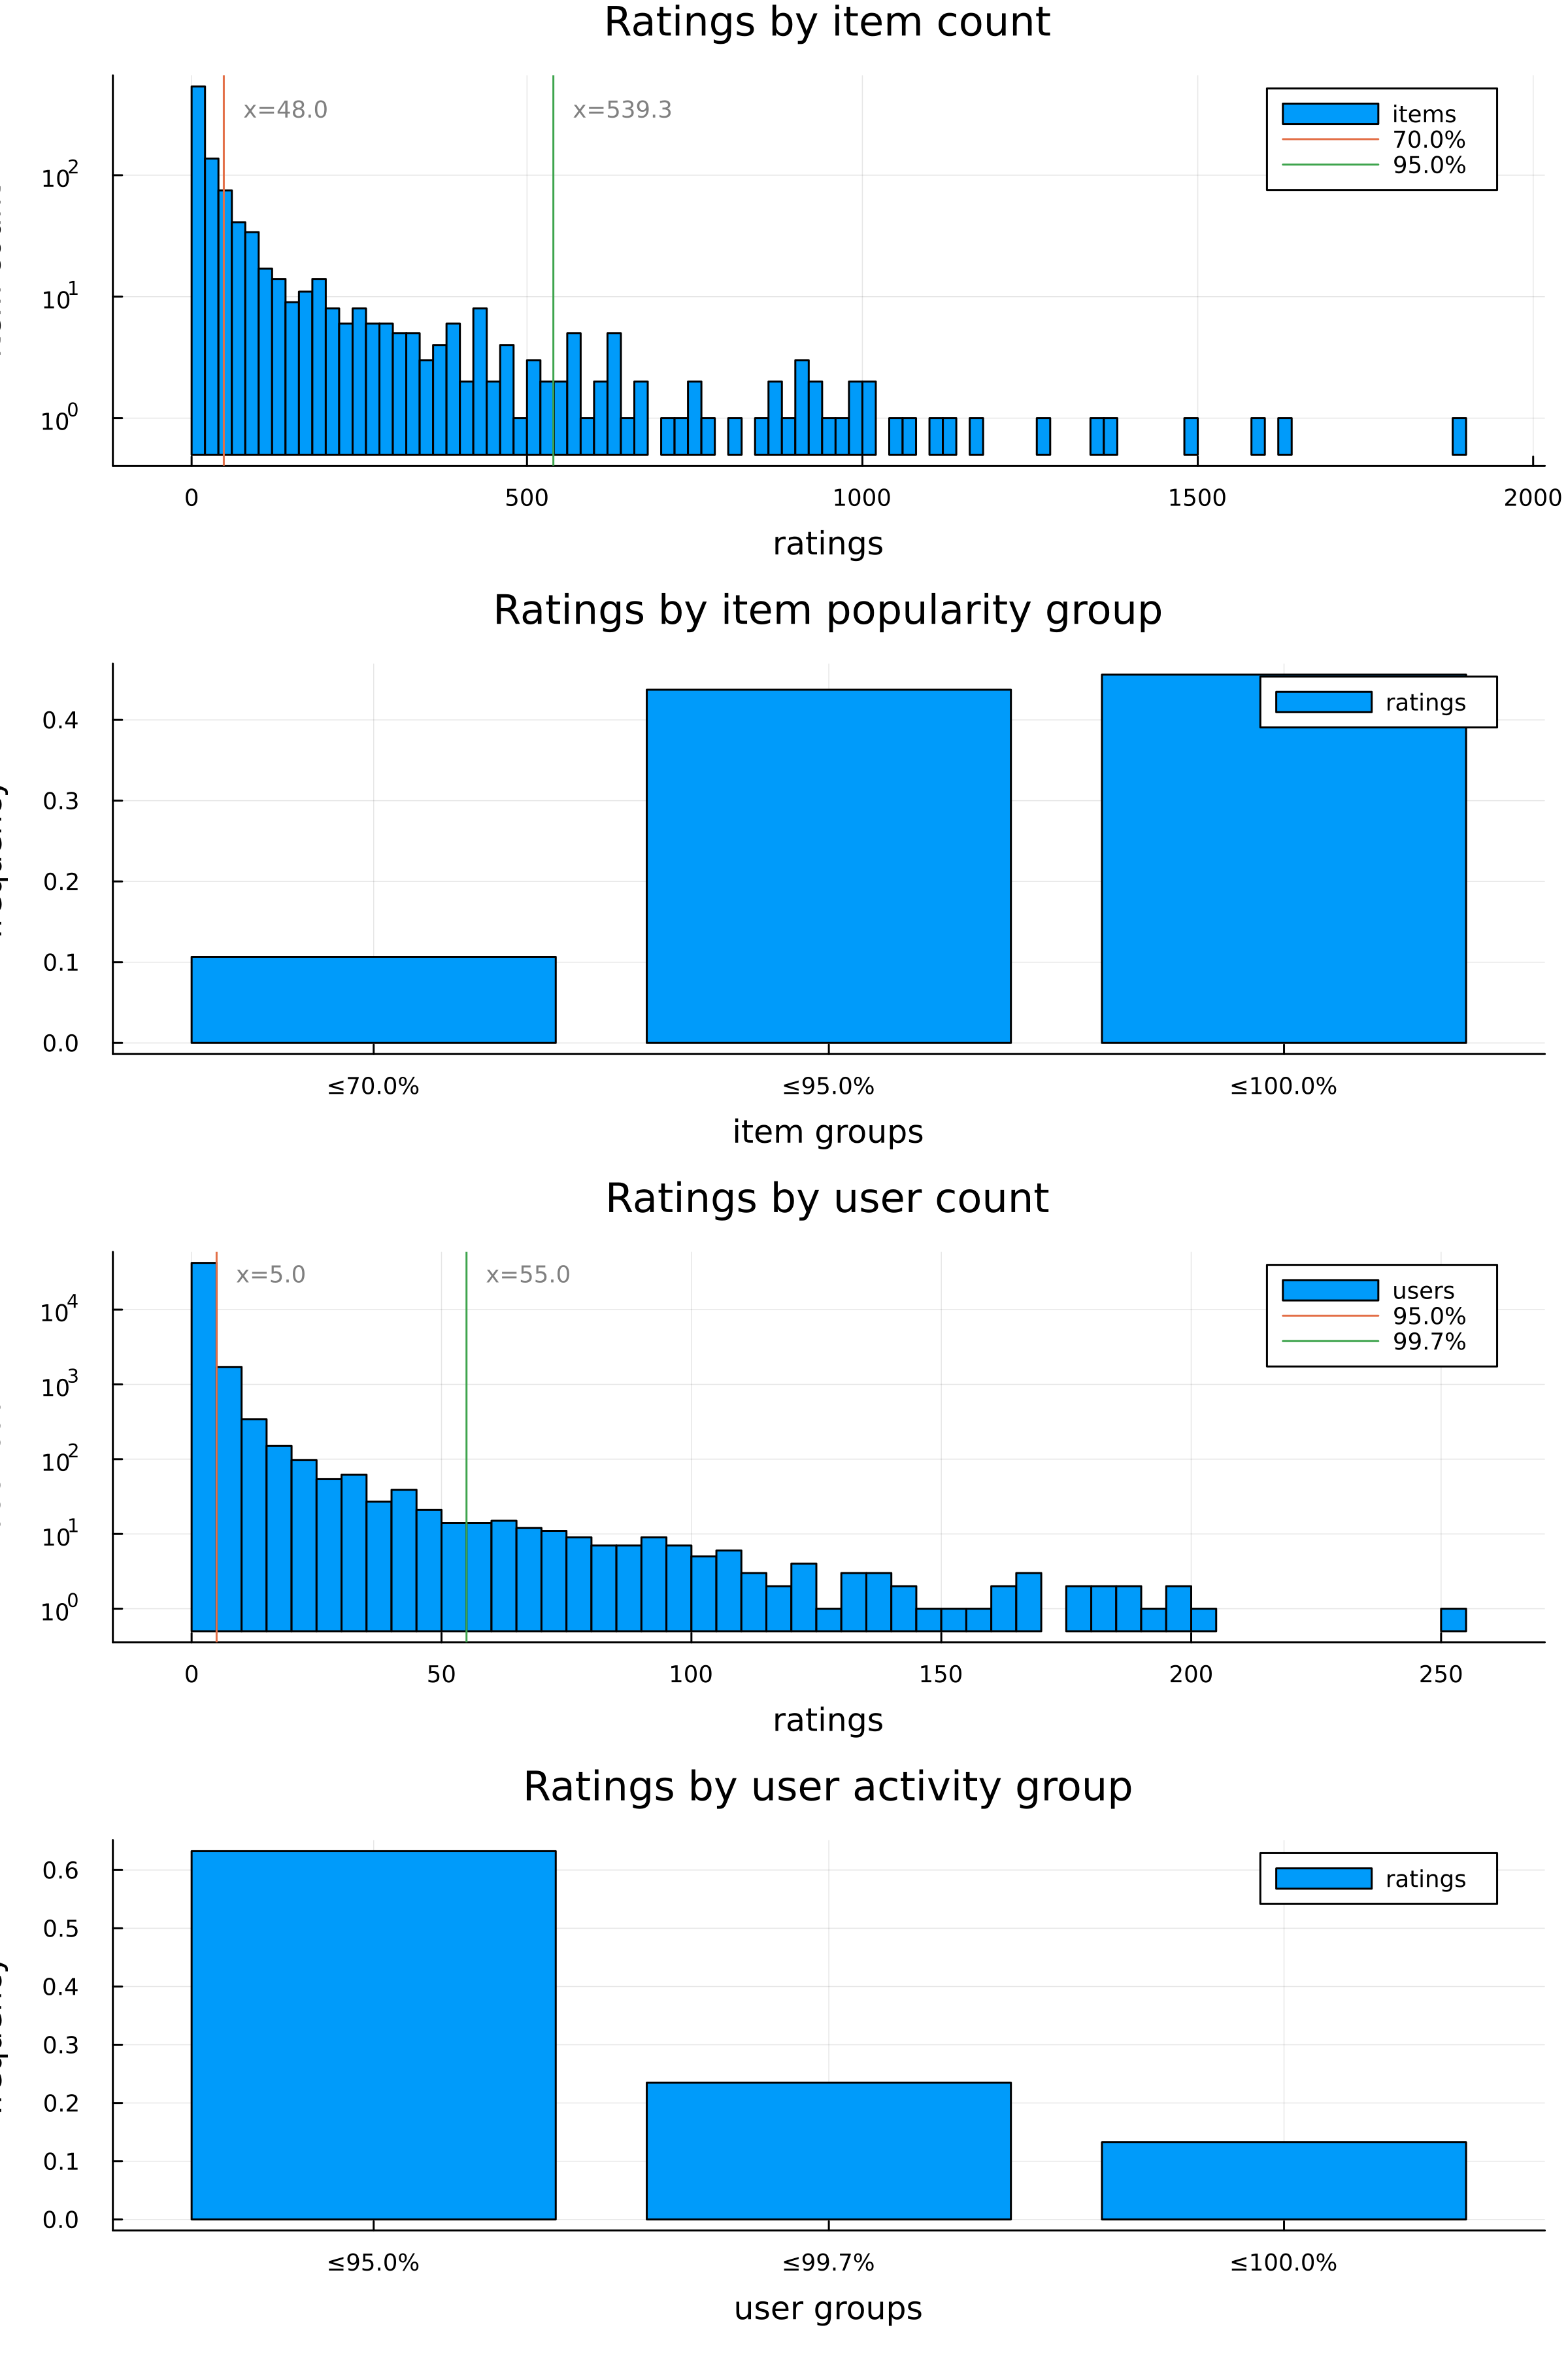

In [9]:
sum_between(df, left, right) = sum(filter(r -> left < r.count && r.count <= right, df).count)

function make_count_plots(df)
    items_quantiles = [0.70, 0.95]
    ratings_by_item = groupby_count(df, :item_id)
    ratings_by_item_hist = histogram(
            ratings_by_item.count, 
            title="Ratings by item count",
            label="items",
            xlabel="ratings",
            ylabel="item count",
            bins=100,
            yscale=:log10,
        )
    annotate_quantiles!(ratings_by_item_hist, ratings_by_item.count, items_quantiles, 30, 350)

    items_quantiles_vals = [quantile(ratings_by_item.count, q) for q in items_quantiles]
    insert!(items_quantiles_vals, 1, 0)
    push!(items_quantiles_vals,999999999999)
    quantile_sums = []
    for i in 1:length(items_quantiles_vals)-1
        push!(
            quantile_sums, 
            sum_between(ratings_by_item, items_quantiles_vals[i], items_quantiles_vals[i+1]) / size(df)[1]
        )
    end
    push!(items_quantiles, 1)
    quantile_sums_items = bar(
        ["≤"*string(round(q * 100, digits=2)) * "%" for q in items_quantiles],
        quantile_sums,
        label="ratings",
        xlabel="item groups",
        ylabel="frequency",
        title="Ratings by item popularity group",
    )
    
    users_quantiles = [0.95, 0.997]
    ratings_by_user = groupby_count(df, :user_id)
    ratings_by_user_hist = histogram(
        ratings_by_user.count, 
        title="Ratings by user count",
        label="users",
        xlabel="ratings",
        ylabel="user count",
        bins=100,
        yscale=:log10,
    )
    annotate_quantiles!(ratings_by_user_hist, ratings_by_user.count, users_quantiles, 4, 30000)

    users_quantiles_vals = [quantile(ratings_by_user.count, q) for q in users_quantiles]
    insert!(users_quantiles_vals, 1, 0)
    push!(users_quantiles_vals, 999999999999)
    quantile_sums = []
    for i in 1:length(users_quantiles_vals)-1
        push!(
            quantile_sums, 
            sum_between(ratings_by_user, users_quantiles_vals[i], users_quantiles_vals[i+1]) / size(df)[1]
        )
    end
    push!(users_quantiles, 1)
    quantile_sums_user = bar(
        ["≤"*string(round(q * 100, digits=2)) * "%" for q in users_quantiles],
        quantile_sums,
        label="ratings",
        xlabel="user groups",
        ylabel="frequency",
        title="Ratings by user activity group",
    )
    
    plot(
        ratings_by_item_hist, 
        quantile_sums_items,
        ratings_by_user_hist,
        quantile_sums_user,
        layout=(4, 1), size=(800,1200), fmt = :png, dpi=300)
    
end

function annotate_quantiles!(p, vec, quantiles, xscaler, ypos)
    for qval in quantiles
        q = quantile(vec, qval)
        vline!(p,
            [q],
            label=string(round(qval * 100, digits=2)) * "%"
        )
        annotate!(p, (q+q*(xscaler/q), ypos, text("x=" * string(round(q, digits=2)), 8, color=:gray, halign=:left)))
    end
end

make_count_plots(ratings_df)

## Exploration interpretations

Notes about the data:
* Keep only events from 2012 to 2018 (inclusive) because the rest of the period is low in ratings
* Rating scores are biased towards higher values
* Some categories are rated more often than others
* All categories have the same rating scores distribution
* Unfortunate assumption: all items have the same price
* +60% of reviews are from occasional buyers (<= 5 reviews)
* ~40% of the reviews are from loyal and vivid clients (> 5 reviews)
* ~70% of items are unpopular and generate only ~10% of the reviews
* the popular and very popular items (~30%) generate 90% of the reviews
* occasional users and unpopular items will cause cold-start problems to the recommandation system

Extracted user personas:
* TODO

Extrated item types:
* TODO

Possible business goals based on user personas:
* TODO

Measures for goals accomplishment:
* TODO

## Julia dependencies

In [8]:
using Pkg

Pkg.add("CategoricalArrays")
Pkg.add("Pipe")
Pkg.add("StatsBase")
Pkg.add("Plots")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("DataFramesMeta")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Ch